In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

In [14]:

#general settings
LSST = True
#if not LSST redhsift kernel
chi0 = chi_cmb/6.
sigma_chi = chi_cmb/14.
bin_num =  1
z_source = 2.#z_cmb
chi_source = chi_z(z_source)
#put a number compatible with maximum of galaxy dis (see above)
chimax = max(chi_source,chi_z(2.))

print('zmax=%d'%z_chi(chimax))


if LSST:
    if chi_source==chi_cmb:
        file_ext = 'lsst%s_cmblens'%str(bin_num)
    else:
        file_ext = 'lsst%s_deltalens_z%d'%(str(bin_num),z_source*10)

else:
    if chi_source==chi_cmb:
        file_ext = 'gaussgal_chi0%d_sigmachi%d_cmblens'%(chi0,sigma_chi)
    else:
        file_ext = 'gaussgal_chi0%d_sigmachi%d_deltalens_z%d'%(chi0,sigma_chi,z_source*10) 
print(file_ext)


params = {}
params['LSST'] = LSST
params['chi0'] = chi0
params['sigma_chi'] = sigma_chi
params['bin_num'] = bin_num
params['chimax'] = chimax
params['chisource'] = chi_source
params['zsource'] = z_source
params['ext'] = file_ext

try: 
    params_ = pickle.load(open('../settings/params_%s.pkl'%file_ext,'rb'))
    assert(params==params_)
except:
    pickle.dump(params,open('../settings/params_%s.pkl'%file_ext,'wb'))



zmax=1
lsst1_deltalens_z20


In [15]:
print('delta lensing with chimax %d'%chimax)
def lensing_kernel(xi):
    xmax = chi_source
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
    
if LSST:
    if bin_num == 'all':
        def galax_kernel(x):
            return lsst_kernel_cb(x)*simple_bias(x)
    else:
        def galax_kernel(x):
            return lsst_kernel_cbn[bin_num](x)*simple_bias(x)
else:
    kernel = Gauss_chi(chi0,sigma_chi)
    def galax_kernel(x):
        return kernel(x)*simple_bias(x)

print(galax_kernel(chimax))

delta lensing with chimax 3597
-8.39246377208e-20


In [16]:
dNdz_LSST(1)

In [17]:
dis_z = dNdz_LSST('all')
np.trapz(dis_z(np.logspace(-2,2)),np.logspace(-2,2))

1.0059750349297247

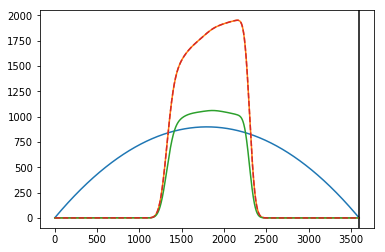

In [18]:
#see if kernels are sensible
test = gal_clus(dNdz_LSST, simple_bias, bin_num)
chis = np.linspace(1,chimax,20000)
plt.plot(chis, lensing_kernel(chis)*chis**2)
plt.plot(chis, galax_kernel(chis)*1e6)
plt.plot(chis, lsst_kernel_cbn[1](chis)*1e6)
plt.axvline(x=chimax, label ='chimax',color='black')
plt.plot(chis, test(chis)*1e6, ls='--')

In [19]:
L = np.logspace(np.log10(min(ell_)),np.log10(1000),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)

### computing auto and cross spectra first

In [20]:
# clkg
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

# chimax and kernels

kernel1  = lensing_kernel
kernel2  = galax_kernel

n = 2

begin=time.time()

chi1fac0 = (kernel1(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I2_ltrc[ii])
    

Cl_pg = chimax * result*1./np.pi**2/2.*prefac/4.*2

print('Time taken = ', time.time()-begin)

Cl_kg = 1./2*(ell_*(ell_+1.))*Cl_pg

np.save('../output/cls/Clkg_%s.npy'%(file_ext),[ell_,Cl_kg])

/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


('Time taken = ', 1.9528820514678955)


In [21]:
#clkk
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

n=0

begin=time.time()

chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-nu_n_.reshape(1, 1, -1))

chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1+z_chi(r2d*t2d*chimax)))
chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d*1./t2d*chimax)*(1+z_chi(r2d/t2d*chimax)))
chi2fac01 = chi2fac01 * t2d**(n+nu_n_.reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I0_ltrc[ii])

Clpp  = 2**2*chimax * result*1./np.pi**2/2.*prefac**2/4. #factor 2 for every phi = -2 int W psi
#factor of 1/2 for every gaussian quadrature

Cl_kk = 1./4*(ell_*(ell_+1.))**2*Clpp

np.save('../output/cls/Clkk_%s.npy'%(file_ext),[ell_,Cl_kk])

print('Time taken = ', time.time()-begin)

/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


('Time taken = ', 2.024549961090088)


In [22]:
#clgg
begin=time.time()

n = 4
chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax))
chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
chi2fac01 = (galax_kernel(1/t2d*r2d*chimax)*D_chi(r2d*1/t2d*chimax))
chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
chi2fac0  = chi2fac00 + chi2fac01

chifacs = w11*w12*chi1fac0* chi2fac0

result=np.zeros_like(ell_)
lmax = ell_.size
for ii  in range(ell_.size):        
    result[ii] = np.sum(chifacs*I4_ltrc[ii])

Cl_gg = chimax * result/np.pi**2/2./4. #dividing by extra factor of 4 (should be there because of Gaussian Quadrature)

np.save('../output/cls/Clgg_%s.npy'%(file_ext),[ell_,Cl_gg])

print('Time taken = ', time.time()-begin)

/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


('Time taken = ', 2.052515983581543)


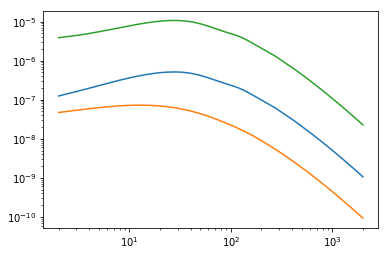

In [23]:
plt.loglog(ell_,Cl_kg)
plt.loglog(ell_,Cl_kk)
plt.loglog(ell_,Cl_gg)

### 1) Terms that also appear in Limber approximation

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$- \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_l^{\delta\psi}(\chi',\chi) C_{|\vec{L}-\vec{l}|}^{\phi\phi}(\chi',\chi) = - \int_{\vec{l}} [\vec{L}\cdot \vec{l}] [\vec{l}\cdot (\vec{L}-\vec{l})]^2 M^{A}(l,|\vec{L}-\vec{l}|)$
after  transform $\vec{l} \rightarrow \vec{l}+\vec{L}$

$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 M^{A}( |\vec{L}+\vec{l}|,l)$

Term 2: 
$ L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') C_L^{\delta\psi}(\chi',\chi) [\frac{1}{2}C_{l}^{\phi\phi}(\chi')+\frac{1}{2}C_{l}^{\phi\phi}(\chi)]$
$ = L^2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 \tilde{M}^{A}(L,l)$

Comparison with Limber results suggest that we are missing a minus sign in Term 2. Will be coding with this Minus sign

Adding Term 1 and 2 with trick from Krause & Hirata:
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$


In [66]:
# naming corresponds to order of axes, files are clphiphi_VB_parallel_split.py and clphiphi_VB_parallel_split2.py
chi1s, chi2s, clphiphirt = np.load('../G_matrices/clphiphi_rt_%s.npy'%file_ext)
chi1s_, chi2s_, clphiphir_over_t = np.load('../G_matrices/clphiphi_r_over_t_%s.npy'%file_ext)
clphiphirt = np.swapaxes(clphiphirt,1,2)
clphiphir_over_t = np.swapaxes(clphiphir_over_t,1,2)

In [67]:
r2d, t2d = np.meshgrid(t_,t_)
#checking if axes of clphiphi are ordered correctly
# print(np.swapaxes(chi2s,0,1)[0],(r2d*t2d*chi_cmb)[0])
# print(np.swapaxes(chi2s_,0,1)[0],(r2d/t2d*chi_cmb)[0])

### Coding the new equation for Term 1:
$\frac{\mathcal A}{2 \pi^2} \sum_n \int dr \chi_{cmb}^{-\nu} r^{-\nu-1} W(r \chi_{cmb},\chi_{cmb}) [1+z(r \chi_{cmb})] D(r \chi_{cmb})\int dt I^{(2)}(\nu_n, t)[ D(tr  \chi_{cmb})W_h(tr  \chi_{cmb}) C_{l1}^{\phi\phi}(tr  \chi_{cmb},r \chi_{cmb})+ t^\nu D(r/t  \chi_{cmb})W_h(r/t  \chi_{cmb}) C_{l1}^{\phi\phi}(r/t  \chi_{cmb},r \chi_{cmb}))]$

In [68]:
#getting MA Eq. 4.4

try: 
    _, M22A = np.load('../M_matrices/M22A_%s.npy'%file_ext)
    M22A_spline = RectBivariateSpline(ell_,ell_,M22A)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

    clphiphirt_ = np.expand_dims(clphiphirt,-1)
    clphiphir_over_t_ = np.expand_dims(clphiphir_over_t,-1)

    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)
        chi1fac0 = (lensing_kernel(r2d*chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphirt_[nn])
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M22A = chimax * result*1./np.pi**2/2.*prefac/4.
    np.save('../M_matrices/M22A_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22A.T])

    M22A_spline = RectBivariateSpline(ell_,ell_,M22A.T)

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
563.382272959


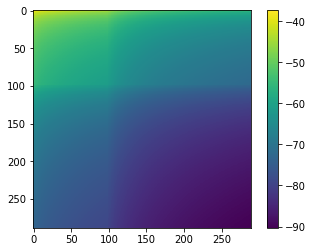

In [69]:
plt.imshow(np.log(M22A))
plt.colorbar()

### clphiphi diag for term 2

In [72]:
# script: clphiphi_VB_parallel.py
clphiphi   = np.load('../G_matrices/clphiphi_parallel_%s.npy'%file_ext)

cl_phiphi_diag= np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    cl_phiphi_diag[:,ii]=clphiphi[:,ii,ii]

clphiphi_diag=[]
from scipy.interpolate import interp1d
for ii in range(len(ell_)):
    clphiphi_diag+=[interp1d(chimax*t_,cl_phiphi_diag[ii])]

In [73]:
#getting tilde MA Eq.4.3

#transpose of code
try:
    _, M31aA = np.load('../M_matrices/M31aA_%s.npy'%file_ext)
    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (galax_kernel(r2d*chimax)*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (lensing_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax)))
        chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*(1.+z_chi(r2d/t2d*chimax)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M31aA = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M31aA_%s.npy'%file_ext,[np.meshgrid(ell_),M31aA.T])

    M31aA_spline = RectBivariateSpline(ell_,ell_,M31aA.T)
    M31aA = M31aA.T

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
602.256394148


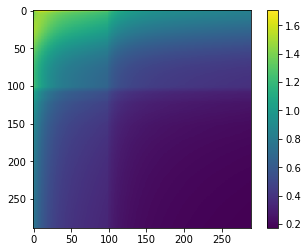

In [74]:
cm = np.load('../output/cm_clmesh/lsst-all_simple/cl31aA.npy')
plt.imshow(M31aA*2/cm)
plt.colorbar()

In [75]:
#getting tilde MA2 (Eq.4.5)
try:
    _, M13a = np.load('../M_matrices/M13a_%s.npy'%file_ext)
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a)
except:
    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    result = np.zeros((len(ell_),len(ell_)))

    n = 2

    begin=time.time()
    for nn in range(len(ell_)):
        if nn%10==0:
            print(nn)

        chi1fac0 = (lensing_kernel(r2d*chimax)*(1+z_chi(r2d*chimax))*D_chi(r2d*chimax)*clphiphi_diag[nn](r2d*chimax))
        chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

        chi2fac00 = (galax_kernel(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax))
        chi2fac01 = (galax_kernel(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w11*w12*chi1fac0* chi2fac0

        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])

    print(time.time()-begin)

    M13a = chimax * result*1./np.pi**2/2.*prefac/4./2.

    np.save('../M_matrices/M13a_%s.npy'%file_ext,[np.meshgrid(ell_),M13a.T])
    
    M13a_spline = RectBivariateSpline(ell_,ell_,M13a.T)
    M13a = M13a.T

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
594.256482124


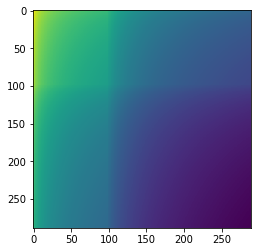

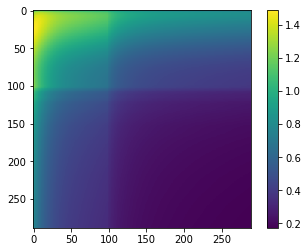

In [76]:
cm = np.load('../output/cm_clmesh/lsst-all_simple/cl13a.npy')

plt.imshow(np.log(M13a))
plt.show()
plt.imshow(np.log(cm))

plt.imshow(M13a*2/cm)
plt.colorbar()

In [77]:
#adding M13A and M31Aa
tildeMA        = M13a+M31aA
tildeMA_spline = RectBivariateSpline(ell_,ell_,tildeMA)

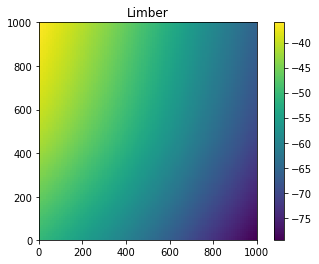

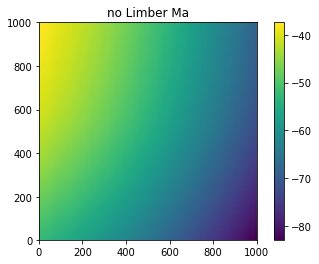

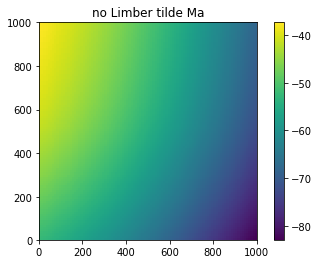

In [78]:
L_, M      = np.load('../output/MLimberSpline_bin_all_cut.npy')
L_         = np.sort(np.unique(L_))


M_Limber   = RectBivariateSpline(L_,L_,M)

plt.title('Limber')
plt.imshow(np.log(M_Limber(L,L,grid=True)),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

M1 = M22A_spline(L,L,grid=True)
plt.title('no Limber Ma')
plt.imshow(np.log(M1),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

M2 =tildeMA_spline(L,L,grid=True)
plt.title('no Limber tilde Ma')
plt.imshow(np.log(M2),extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

In [79]:
M = M_Limber(L,L,grid=True)

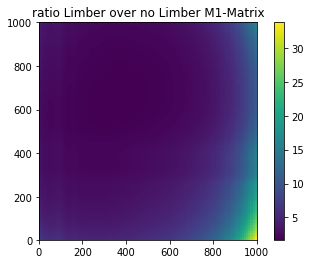

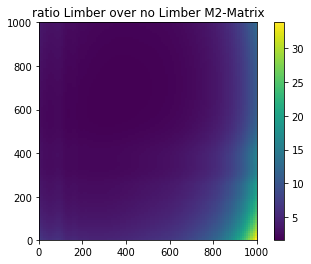

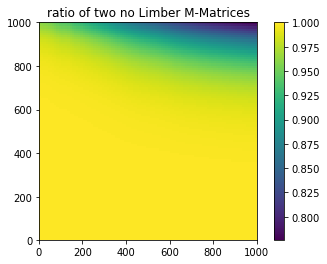

In [80]:
plt.title('ratio Limber over no Limber M1-Matrix')
plt.imshow(M/M1,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

plt.title('ratio Limber over no Limber M2-Matrix')
plt.imshow(M/M2,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

plt.title('ratio of two no Limber M-Matrices')
plt.imshow(M1/M2,extent=(L[0],L[-1],L[0],L[-1]))
plt.colorbar()
plt.show()

In [81]:
# sampling for integrations
#31 term only
def get_31_term_only(L,L1,M):
    return -L**4/np.pi*simps(M(L,L1)*L1**3,L1)/4.

In [82]:
phi       = np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1        = np.logspace(np.log(2),3,400)
term31    = get_31_term_only(L1=l,L=L, M=tildeMA_spline)
term31_Li = get_31_term_only(L1=l,L=L, M=M_Limber)

In [83]:
L_, Cl31s  = np.load('../output/LimberPostBornCl31_kappa-gal.npy')
LL,LL1,CL31_cut = np.load('../output/LimberPostBornCl31_kappa-gal_all_cut.npy')
print(CL31_cut)

[ -1.53458642e-14  -1.68028917e-14  -1.83968452e-14  -2.01404018e-14
  -2.20473873e-14  -2.41328773e-14  -2.64133068e-14  -2.89065886e-14
  -3.16322417e-14  -3.46115307e-14  -3.78676161e-14  -4.14257175e-14
  -4.53132893e-14  -4.95602118e-14  -5.41989963e-14  -5.92650079e-14
  -6.47967054e-14  -7.08359001e-14  -7.74280356e-14  -8.46224889e-14
  -9.24728957e-14  -1.01037500e-13  -1.10379532e-13  -1.20567609e-13
  -1.31676129e-13  -1.43785748e-13  -1.56983885e-13  -1.71365262e-13
  -1.87032474e-13  -2.04096605e-13  -2.22677879e-13  -2.42906303e-13
  -2.64922409e-13  -2.88878081e-13  -3.14937407e-13  -3.43277593e-13
  -3.74089907e-13  -4.07580538e-13  -4.43971720e-13  -4.83502942e-13
  -5.26432179e-13  -5.73037139e-13  -6.23616312e-13  -6.78490515e-13
  -7.38004511e-13  -8.02528596e-13  -8.72459818e-13  -9.48223664e-13
  -1.03027619e-12  -1.11910586e-12  -1.21523477e-12  -1.31922092e-12
  -1.43166075e-12  -1.55319050e-12  -1.68448806e-12  -1.82627618e-12
  -1.97932385e-12  -2.14444812e-12

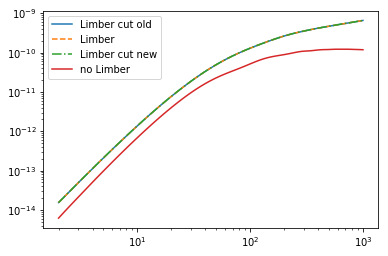

In [84]:
plt.figure()
plt.loglog(LL, -CL31_cut,label='Limber cut old',ls='-')
plt.plot(L_, -Cl31s[-1],label='Limber', ls='--')
plt.plot(L, -term31_Li,label='Limber cut new', ls='-.')
plt.plot(L, -term31, label = 'no Limber')
plt.legend()

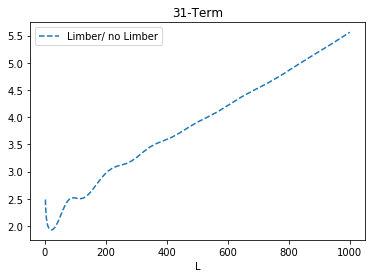

In [85]:
plt.figure()
plt.title('31-Term')
# plt.plot(LL, CL31_cut,label='Limber cut old')
# plt.plot(L, Cl31s[-1],label='Limber', ls='--')
plt.plot(L, term31_Li/term31,label= 'Limber/ no Limber',ls='--')
plt.xlabel('L')
plt.legend()

## Now that we have $M^A$ s: coding this equations
$\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2 [M^{A}( |\vec{L}+\vec{l}|,l)-\tilde{M}^{A}(L,l)] +  \left[\int_{\vec{l}} [\vec{L}\cdot  (\vec{L}+\vec{l})] [\vec{l}\cdot (\vec{L}+\vec{l})]^2-L^2[\vec{L}\cdot \vec{l}]^2\right] \tilde{M}^{A}(L,l)$

In [86]:
def get_regularized_sum_of_terms(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand = LL1*(LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*((LL**2+LL*LL1*nu)*(LL1**2+LL*LL1*nu)**2-LL**2*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

In [87]:
# use same sampling as in Limber case

# sampling for integrations
phi = np.linspace(0.,2.*np.pi,1000,endpoint=True)

In [88]:
MA_spline       = M22A_spline
tildeMA_spline  = tildeMA_spline

begin = time.time()
all_bins = get_regularized_sum_of_terms(L,l,phi,MA_spline,tildeMA_spline,method='trapz')+get_second_sum_of_terms(L,l,tildeMA_spline,method='trapz')
print(time.time()-begin)

np.save('../output/results/term1_%s'%file_ext,[L,all_bins])

23.1970961094


In [89]:
sum_Limber =  get_regularized_sum_of_terms(L,l,phi,M_Limber,M_Limber,method='trapz')+get_second_sum_of_terms(L,l,M_Limber,method='trapz')

In [90]:
L_, corrs    = np.load('../output/LimberPostBornResultsLSST.npy')
L_2, corrs_cut = np.load('../output/LimberPostBornResultsLSST_cut.npy')

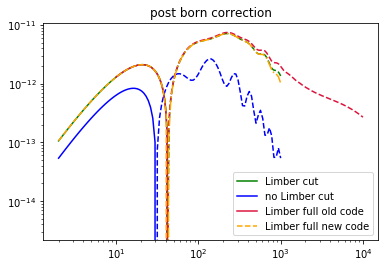

In [91]:
plt.figure()
plt.title('post born correction')
plt.loglog(L_2,corrs_cut[-1],label='Limber cut',color='g')
plt.loglog(L_2,-corrs_cut[-1],color='g',ls='--')
plt.loglog(L,all_bins,label='no Limber cut',color='b')
plt.loglog(L,-all_bins,color='b',ls='--')
plt.loglog(L_,corrs[-1],label='Limber full old code',color='crimson')
plt.loglog(L_,-corrs[-1],ls='--',color='crimson')
plt.loglog(L,sum_Limber,label='Limber full new code',ls='--',color='orange')
plt.loglog(L,-sum_Limber,ls='-.',color='orange')
plt.legend()

(0.0, 2)

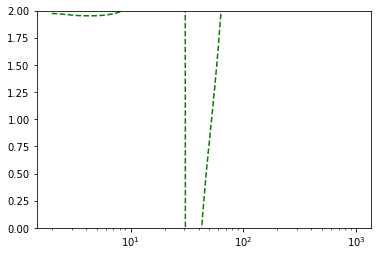

In [92]:
#ration restricted Limber to no Limber
plt.semilogx(L,sum_Limber/all_bins,color='g',ls='--')
plt.ylim(0.0,2)

# additional terms that are zero in Limber

## Eq. 4.2

In [93]:

# clphipsi code
try:
    Cl = np.load('../G_matrices/clphipsi_%s.npy'%file_ext)
except:
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)
    chi2_max = chimax
    chi1_max = chimax

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    # inflate by one dimensions (nu_n)
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chi1_max in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        #psi goes with chi2
        chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
        chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

        # no lensing kernel, because no lensing integration of chi_2
        chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*inner_kernel(r2d*t2d*chi2_max, chi1_max))

        chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*inner_kernel(r2d*1./t2d*chi2_max, chi1_max))

        chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result = np.zeros((len(ell_),len(t_)))
        lmax   = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

        #jj is chi1 -> phi
        Cl[jj] = result*1./np.pi**2/2.*prefac**2 #divide by to for Gauss quad and times two for phi cancel
    # swap axes to have cl_phipsi_l(chi_max,chi)
    Cl = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)

    # first axis ell, second phi, third psi
    np.save('../G_matrices/clphipsi_%s'%file_ext,Cl)
    
clphipsi = np.swapaxes(Cl,1,2)

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:43: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
('Time taken = ', 221.70768809318542)


In [94]:
# clphidelta
try:
    cldeltaphi = np.load('../G_matrices/clphidelta_%s.npy'%file_ext)
except:
    
    def inner_kernel(xi, xmax):
        return (xmax - xi)/(xmax*xi) * (xmax > xi)

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)
    #nu axis
    r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
    w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


    chimax2   = chimax

    n = 2

    Cl = np.zeros((len(t_),len(ell_),len(t_)))

    begin=time.time()

    for jj, chimax1 in enumerate((t_*chimax)):
        if jj%10==0:
            print(jj)

        chi1fac0  = D_chi(r2d*chimax2)
        chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))

        chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*inner_kernel(r2d*t2d*chi2_max, chimax1))

        chi2fac01 = (inner_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
        chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
        chi2fac0  = chi2fac00 + chi2fac01

        chifacs   = w12*chi1fac0* chi2fac0

        result    = np.zeros((len(ell_),len(t_)))
        lmax = ell_.size
        for ii  in range(ell_.size):        
            result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))

        Cl[jj] = result*1./np.pi**2/2.*prefac/2.*2

    cldeltaphi = np.swapaxes(Cl,0,1)
    print('Time taken = ', time.time()-begin)


    # first axis ell, second phi, third delta
    np.save('../G_matrices/clphidelta_%s'%file_ext,cldeltaphi)

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:42: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
('Time taken = ', 200.74870014190674)


In [95]:
try:
    _ ,M22B = np.load('../M_matrices/M22B_%s.npy'%str(file_ext))
except:
    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*chimax**2*kernel1(r2d*chimax)*kernel2(t2d*chimax)*cldeltaphi[ii]*clphipsi[jj])/4.

    M22B = result

    # first index is L-l, second index is l
    np.save('../M_matrices/M22B_%s.npy'%str(file_ext),[np.meshgrid(ell_),M22B])

M22B_spline = RectBivariateSpline(ell_,ell_,M22B)

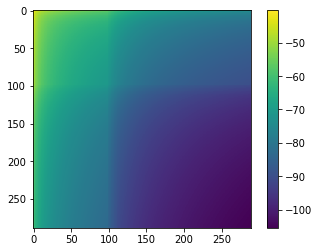

In [96]:
plt.imshow(np.log(M22B))
plt.colorbar()

In [97]:
clphipsi_diag = np.zeros((len(ell_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag[:,ii]=clphipsi[:,ii,ii]

clphipsi_diag_blown=np.zeros((len(ell_),len(t_),len(t_)))
for ii in range(len(t_)):
    clphipsi_diag_blown[:,ii]=clphipsi_diag


In [98]:
try:
    _ , M31aB = np.load('../M_matrices/M31aB_%s.npy'%file_ext)
except:
    cldeltaphi=cldeltaphi.swapaxes(1,2)

    kernel1 = galax_kernel
    kernel2 = lensing_kernel

    r2d, t2d = np.meshgrid(t_,t_)
    w11, w12 = np.meshgrid(w1,w1)

    result = np.zeros((len(ell_),len(ell_)))
    for ii in range(len(ell_)):
        for jj in range(len(ell_)):
            result[ii][jj] = np.sum(w11*w12*kernel1(t2d*chimax)*kernel2(r2d*chimax)*clphipsi_diag_blown[jj]*cldeltaphi[ii])
    result*=chimax**2/4.

    M31aB = result

    # first index is L
    np.save('../M_matrices/M31aB_%s.npy'%file_ext,[np.meshgrid(ell_),M31aB])

M31aB_spline = RectBivariateSpline(ell_,ell_,M31aB)

In [99]:
def get_regularized_sum_of_terms_2(L,L1,phi,M1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand = -LL*LL1*nu*(LL*LL1*nu-LL1**2)**2*LL1*(M1(L_,LL1,grid=False)-M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res


#numerical angular integration
def get_second_sum_of_terms_2(L,L1,M2,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand =  LL1*(((LL*LL1*nu)**2*LL1**2)-LL*LL1*nu*(LL*LL1*nu-LL1**2)**2)*(M2(LL,LL1,grid=False))
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=np.asarray(res)/(2.*np.pi)**2
    return res

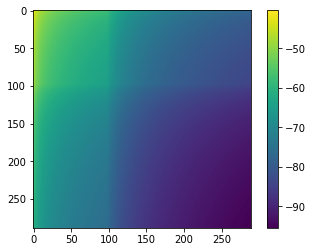

In [100]:
plt.imshow(np.log(M31aB))
plt.colorbar()

In [101]:
all_bins2 = get_regularized_sum_of_terms_2(L,l,phi,M22B_spline,M31aB_spline,method='trapz')+get_second_sum_of_terms_2(L,l,M31aB_spline,method='trapz')
np.save('../output/results/term2_%s'%file_ext,[L,all_bins2])

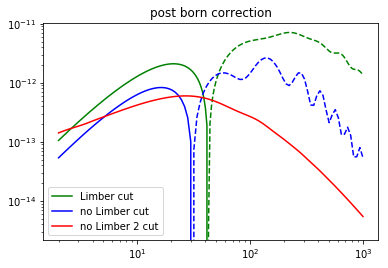

In [102]:
plt.figure()
plt.title('post born correction')
plt.loglog(L_2,corrs_cut[-1],label='Limber cut',color='g')
plt.loglog(L_2,-corrs_cut[-1],color='g',ls='--')
plt.loglog(L,all_bins,label='no Limber cut',color='b')
plt.loglog(L,-all_bins,color='b',ls='--')
plt.loglog(L,all_bins2,label='no Limber 2 cut',color='r')
plt.loglog(L,-all_bins2,color='r',ls='--')
plt.legend()

In [103]:
# #getting M-Matrix for kappa 31 auto spectrum correction
# def lensing_kernel(xi):
#     xmax = chi_cmb
#     return (xmax - xi)/(xmax*xi) * (xmax > xi)

# #transpose of code
# try:
#     _, M31Aa = np.load('../M_matrices/M31kappaauto_%s.npy'%'cmb')
#     M31kappa_spline = RectBivariateSpline(ell_,ell_,M31Aa)
# except:
#     r2d, t2d = np.meshgrid(t_,t_)
#     w11, w12 = np.meshgrid(w1,w1)
#     #nu axis
#     r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
#     w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


#     result = np.zeros((len(ell_),len(ell_)))

#     n = 0

#     begin=time.time()
#     for nn in range(len(ell_)):
#         if nn%10==0:
#             print(nn)

#         chi1fac0 = (lensing_kernel(r2d*chi_source)*D_chi(r2d*chi_source)*(1.+z_chi(r2d*chi_source))*clphiphi_diag[nn](r2d*chimax))
#         chi1fac0 = chi1fac0 *(r2d*chi_source)**(1-(n+nu_n_.reshape(1, 1, -1)))

#         chi2fac00 = (lensing_kernel(t2d*r2d*chi_source)*D_chi(r2d*t2d*chi_source)*(1.+z_chi(r2d*t2d*chi_source)))
#         chi2fac01 = (lensing_kernel(1./t2d*r2d*chi_source)*D_chi(r2d/t2d*chi_source)*(1.+z_chi(r2d/t2d*chi_source)))
#         chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
#         chi2fac0  = chi2fac00 + chi2fac01

#         chifacs   = w11*w12*chi1fac0* chi2fac0

#         lmax = ell_.size
#         for ii  in range(ell_.size):        
#             result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])

#     print(time.time()-begin)

#     M31Aa = chi_source * result*1./np.pi**2/2.*prefac**2/4.

#     np.save('../M_matrices/M31kappaauto_zs%s.npy'%str(z_source*10),[np.meshgrid(ell_),M31Aa.T])
#     M31kappa_spline = RectBivariateSpline(ell_,ell_,M31Aa.T)


In [104]:
#L1,L2, M32autoLimber = np.load('../output/MLimberClKappaAuto.npy')
#L = np.unique(L1.flatten())

In [ ]:
#M32autopostLimber = M31kappa_spline(L,L,grid=True)

In [ ]:
#plt.imshow(np.log(M32autoLimber))
#plt.colorbar()

In [ ]:
#plt.imshow(np.log(M32autopostLimber))
#plt.colorbar()

In [ ]:
#plt.imshow(M32autoLimber/M32autopostLimber)
#plt.colorbar()

In [ ]:
# M32autoLimber = RectBivariateSpline(L,L,M32autoLimber)
# M32autopostLimber = RectBivariateSpline(L,L,M32autopostLimber)

# def get_31_term_auto(L,L1,M):
#     return L**6/np.pi*simps(M(L,L1)*L1**3,L1)/4.

# phi       = np.linspace(0.,2.*np.pi,1000,endpoint=True)
# L1        = np.logspace(np.log(2),3,400)
# term31_Li    = get_31_term_auto(L1=L1,L=L, M=M32autoLimber)
# term31 = get_31_term_auto(L1=L1,L=L, M=M32autopostLimber)

In [ ]:
# plt.figure()
# plt.loglog(L, term31)
# plt.plot(L, term31_Li)

In [ ]:
# plt.figure()
# plt.plot(L, term31_Li/term31, label='Limber /no Limber')
# plt.legend()
# plt.grid()